# Question 1: Multi Layer Perceptron


## Task :

<ul>
<li>Train MLP for MNIST</li>
<li>Knowledge Distillation</li>
</ul>


# Data Preprocessing


<img src="Images/Q4-prep.png" width = 500>


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PyTorch for Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# TensorFlow and Keras for Deep Learning
import tensorflow as tf
from tensorflow import keras

# scikit-learn for clustering
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score

import seaborn as sns
import torchvision


### 1. Load data set / report the number and dimensions of training and test data


In [18]:

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, shuffle=True)

test_dataset = torchvision.datasets.MNIST(
    root='./data', train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=64, shuffle=False)


In [19]:
num_train_samples = len(train_dataset)
train_data_dimensions = train_dataset[0][0].shape

num_test_samples = len(test_dataset)
test_data_dimensions = test_dataset[0][0].shape

print("Training Data:")
print(f"Number of Samples: {num_train_samples}")
print(f"Data Dimensions: {train_data_dimensions}")

print("\nTest Data:")
print(f"Number of Samples: {num_test_samples}")
print(f"Data Dimensions: {test_data_dimensions}")


Training Data:
Number of Samples: 60000
Data Dimensions: torch.Size([1, 28, 28])

Test Data:
Number of Samples: 10000
Data Dimensions: torch.Size([1, 28, 28])


### 2. Show an example of each class


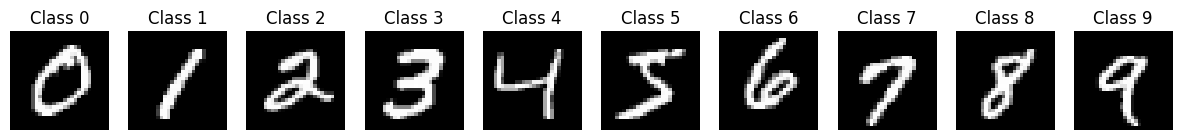

In [20]:

class_shown = {}

fig, axs = plt.subplots(1, 10, figsize=(15, 2))

for i in range(len(train_dataset)):
    image, label = train_dataset[i]
    label = int(label)
    if label not in class_shown:
        ax = axs[label]
        ax.imshow(image[0], cmap='gray')
        ax.set_title(f'Class {label}')
        ax.axis('off')
        class_shown[label] = True

    if len(class_shown) == 10:
        break

plt.show()


### 3. Draw histogram chart for training data


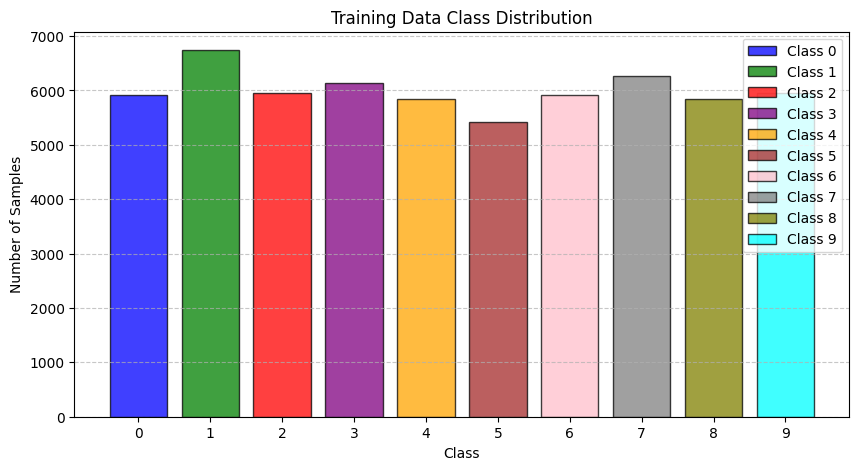

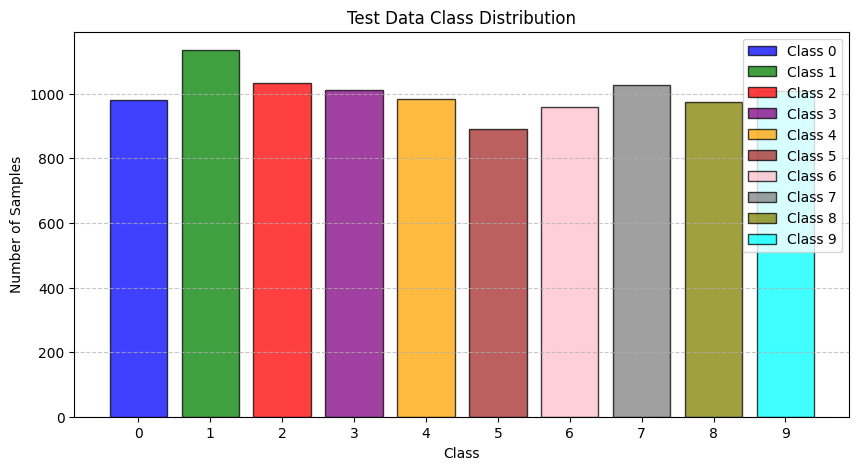

In [21]:
colors = ['blue', 'green', 'red', 'purple', 'orange',
          'brown', 'pink', 'gray', 'olive', 'cyan']


def plot_class_histogram(dataset, title):
    labels = [int(label) for _, label in dataset]
    unique_labels = list(set(labels))

    plt.figure(figsize=(10, 5))
    for i, label in enumerate(unique_labels):
        color = colors[i % len(colors)]
        plt.hist(
            [label for label in labels if label == unique_labels[i]],
            bins=[unique_labels[i] - 0.5, unique_labels[i] + 0.5],
            align='mid',
            rwidth=0.8,
            alpha=0.75,
            edgecolor='black',
            color=color,
            label=f'Class {unique_labels[i]}'
        )

    plt.xticks(range(10))
    plt.xlabel("Class")
    plt.ylabel("Number of Samples")
    plt.title(title)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(loc='best')


# Plot the histogram for the training data
plot_class_histogram(train_dataset, title="Training Data Class Distribution")
plt.show()

# Plot the histogram for the test data
plot_class_histogram(test_dataset, title="Test Data Class Distribution")
plt.show()


### 4. Scaling using min-max normalization


In [22]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(
        lambda x: (x - x.min()) / (x.max() - x.min()))
])

train_dataset_normalized = torchvision.datasets.MNIST(
    root='./data', train=True, transform=transform, download=True)
train_loader_normalized = torch.utils.data.DataLoader(
    train_dataset_normalized, batch_size=64, shuffle=True)

test_dataset_normalized = torchvision.datasets.MNIST(
    root='./data', train=False, transform=transform, download=True)
test_loader_normalized = torch.utils.data.DataLoader(
    test_dataset_normalized, batch_size=64, shuffle=False)


---


## Teacher Network


In [23]:
class Teacher(nn.Module):
    def __init__(self):
        super(Teacher, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 1024)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(1024, 512)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(512, 10)
        self.relu3 = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        return x


In [24]:
teacher = Teacher()


In [25]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(teacher.parameters(), lr=0.01)

# Training parameters
batch_size = 32
num_epochs = 20

# Data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset_normalized, batch_size=batch_size, shuffle=True)

# Lists to store training history
train_loss_history = []
train_accuracy_history = []


In [26]:


# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = teacher(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = (correct_predictions / total_samples) * 100

    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_accuracy)

    print(
        f'Epoch [{epoch + 1}/{num_epochs}] - Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%')


Epoch [1/20] - Loss: 1.0779, Accuracy: 75.75%
Epoch [2/20] - Loss: 0.3546, Accuracy: 89.93%
Epoch [3/20] - Loss: 0.2879, Accuracy: 91.81%
Epoch [4/20] - Loss: 0.2483, Accuracy: 92.90%
Epoch [5/20] - Loss: 0.2176, Accuracy: 93.81%
Epoch [6/20] - Loss: 0.1924, Accuracy: 94.54%
Epoch [7/20] - Loss: 0.1716, Accuracy: 95.08%
Epoch [8/20] - Loss: 0.1539, Accuracy: 95.56%
Epoch [9/20] - Loss: 0.1386, Accuracy: 96.06%
Epoch [10/20] - Loss: 0.1261, Accuracy: 96.41%
Epoch [11/20] - Loss: 0.1153, Accuracy: 96.77%
Epoch [12/20] - Loss: 0.1059, Accuracy: 97.05%
Epoch [13/20] - Loss: 0.0974, Accuracy: 97.26%
Epoch [14/20] - Loss: 0.0899, Accuracy: 97.44%
Epoch [15/20] - Loss: 0.0832, Accuracy: 97.65%
Epoch [16/20] - Loss: 0.0773, Accuracy: 97.86%
Epoch [17/20] - Loss: 0.0717, Accuracy: 98.02%
Epoch [18/20] - Loss: 0.0670, Accuracy: 98.17%
Epoch [19/20] - Loss: 0.0628, Accuracy: 98.27%
Epoch [20/20] - Loss: 0.0585, Accuracy: 98.43%


#### save / load model


In [27]:
model_path = 'teacher_model.pth'


In [28]:


torch.save(teacher.state_dict(), model_path)


In [29]:
loaded_teacher = Teacher()
loaded_teacher.load_state_dict(torch.load(model_path))
loaded_teacher.eval()


Teacher(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (relu3): ReLU()
)

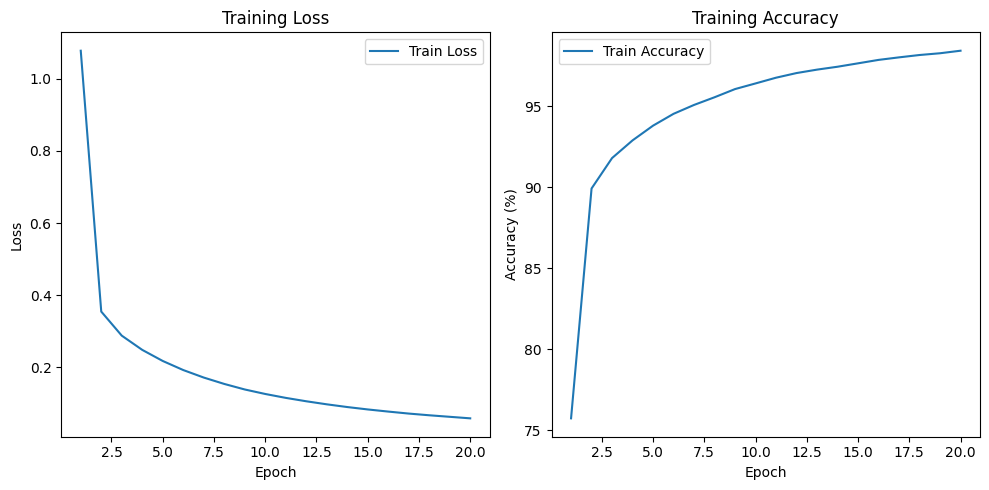

In [30]:

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_loss_history, label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1),
         train_accuracy_history, label='Train Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


#### logit:

To find the class predicted by network from the logit output in PyTorch, we can use the `torch.max(output.data,1)` function. The mentioned function will find index of maximum value among the class scores of the output values and retun predicted class.

`The accurac`y is division of number of correct answers per total samples.

`The miss-classification` is difference total number of samples and the correct predictions.


In [31]:
teacher.eval()
correct_predictions = 0
total_samples = 0

with torch.no_grad():
    for inputs, labels in test_loader_normalized:
        outputs = teacher(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

test_accuracy = (correct_predictions / total_samples) * 100

print(f'Test Accuracy: {test_accuracy:.2f}%')

# Calculate the number of misclassifications
misclassifications = total_samples - correct_predictions
print(f'Number of Misclassifications: {misclassifications}')


Test Accuracy: 97.54%
Number of Misclassifications: 246


---


## Student Network


In [59]:
class Student(nn.Module):
    def __init__(self):
        super(Student, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 10)
        self.relu3 = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        return x


In [33]:
student = Student()


In [60]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(student.parameters(), lr=0.01)

batch_size = 32
num_epochs = 10

# Data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset_normalized, batch_size=batch_size, shuffle=True)

# Lists to store training history
train_loss_history = []
train_accuracy_history = []


In [35]:
# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = student(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = (correct_predictions / total_samples) * 100

    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_accuracy)

    print(
        f'Epoch [{epoch + 1}/{num_epochs}] - Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%')


Epoch [1/10] - Loss: 1.7392, Accuracy: 46.37%
Epoch [2/10] - Loss: 1.1853, Accuracy: 55.79%
Epoch [3/10] - Loss: 1.1249, Accuracy: 56.60%
Epoch [4/10] - Loss: 1.0979, Accuracy: 57.04%
Epoch [5/10] - Loss: 1.0800, Accuracy: 57.40%
Epoch [6/10] - Loss: 1.0651, Accuracy: 57.64%
Epoch [7/10] - Loss: 1.0521, Accuracy: 58.00%
Epoch [8/10] - Loss: 1.0409, Accuracy: 58.21%
Epoch [9/10] - Loss: 1.0311, Accuracy: 58.42%
Epoch [10/10] - Loss: 1.0227, Accuracy: 58.57%


#### save / load model


In [61]:
model_path = 'student_model.pth'


In [45]:
torch.save(student.state_dict(), model_path)


In [62]:
loaded_student = Student()
loaded_student.load_state_dict(torch.load(model_path))
loaded_student.eval()


Student(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (relu3): ReLU()
)

Number of Misclassifications on Test Data: 24859


ValueError: x and y must have same first dimension, but have shapes (10,) and (0,)

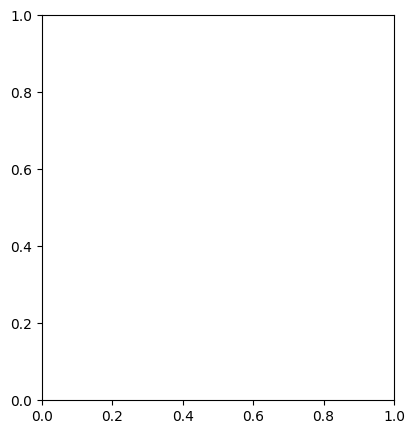

In [63]:
misclassifications = total_samples - correct_predictions
print(f'Number of Misclassifications on Test Data: {misclassifications}')


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_loss_history, label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1),
         train_accuracy_history, label='Train Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


---


## Knowledge Distillation


In [46]:
student_kd = Student()


In [52]:

# Define the loss function as Mean Squared Error (MSE)
criterion_kd = nn.MSELoss()

optimizer_kd = optim.SGD(student_kd.parameters(), lr=0.01)

batch_size = 32
num_epochs = 10

teacher_train_loader = DataLoader(
    train_dataset_normalized, batch_size=batch_size, shuffle=True)

train_loss_history_kd = []


In [53]:
student_kd.train()  # Set the Student model to training mode

for epoch in range(num_epochs):
    running_loss = 0.0

    teacher_train_iter = iter(teacher_train_loader)

    for inputs, labels in train_loader:
        optimizer_kd.zero_grad()
        outputs_kd = student_kd(inputs)

        # Get Teacher's logits from the Teacher data loader
        teacher_inputs, _ = next(teacher_train_iter)
        teacher_logits = teacher(teacher_inputs)

        loss_kd = criterion_kd(outputs_kd, teacher_logits)
        loss_kd.backward()
        optimizer_kd.step()

        running_loss += loss_kd.item()

    train_loss_kd = running_loss / len(train_loader)
    train_loss_history_kd.append(train_loss_kd)

    print(f'Epoch [{epoch + 1}/{num_epochs}] - Loss: {train_loss_kd:.4f}')


Epoch [1/10] - Loss: 19.6216
Epoch [2/10] - Loss: 19.6175
Epoch [3/10] - Loss: 19.6138
Epoch [4/10] - Loss: 19.6100
Epoch [5/10] - Loss: 19.6080
Epoch [6/10] - Loss: 19.6072
Epoch [7/10] - Loss: 19.6072
Epoch [8/10] - Loss: 19.6069
Epoch [9/10] - Loss: 19.6060
Epoch [10/10] - Loss: 19.6065


In [56]:
correct_predictions_kd_test = 0
total_samples_kd_test = 0

for inputs, labels in test_loader_normalized:
    outputs_kd = student_kd(inputs)
    _, predicted_kd = torch.max(outputs_kd.data, 1)
    total_samples_kd_test += labels.size(0)
    correct_predictions_kd_test += (predicted_kd == labels).sum().item()

misclassifications_kd_test = total_samples_kd_test - correct_predictions_kd_test
print(
    f'Number of Misclassifications with Knowledge Distillation on Test Data: {misclassifications_kd_test}')


Number of Misclassifications with Knowledge Distillation on Test Data: 8990


#### 1. Compare the number of misclassifications (Student model of the previous section on the test data with the current Student model and report the result


The comparison between the number of misclassifications on the test data using Knowledge Distillation and normal training shows that Knowledge Distillation has significantly reduced the misclassifications:

- With Knowledge Distillation: Number of Misclassifications on Test Data: 8,990
- Without Knowledge Distillation (normal training): Number of Misclassifications on Test Data: 24,859

Using Knowledge Distillation, the Student model has learned to imitate the Teacher model's outputs, leading to improved generalization and a substantial reduction in misclassifications on the test data. This demonstrates the effectiveness of Knowledge Distillation in transferring knowledge from a larger model (Teacher) to a smaller model (Student).


#### 2. Draw the accuracy of both Student models on the train data during training in a graph and explain the effects of using Distillation Knowledge.
